In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
monthly_sales = pd.read_csv('/content/drive/MyDrive/CSV files/Maruti_sales.csv')
monthly_sales.head()

,month-year,Sales
0,Jan-18,140600
1,Feb-18,137900
2,Mar-18,148582
3,Apr-18,164978
4,May-18,163200


In [4]:
dates = pd.date_range(start = "2018-01-01", freq="MS", periods= len(monthly_sales))
dates

DatetimeIndex(['2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01',
               '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01',
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
      

In [8]:
import calendar
monthly_sales['Date'] = dates
monthly_sales['Sale'] = monthly_sales['Sales']


In [10]:
monthly_sales.drop(["month-year","Sales"], axis=1, inplace= True)
monthly_sales.head()

,Date,Sale
0,2018-01-01,140600
1,2018-02-01,137900
2,2018-03-01,148582
3,2018-04-01,164978
4,2018-05-01,163200


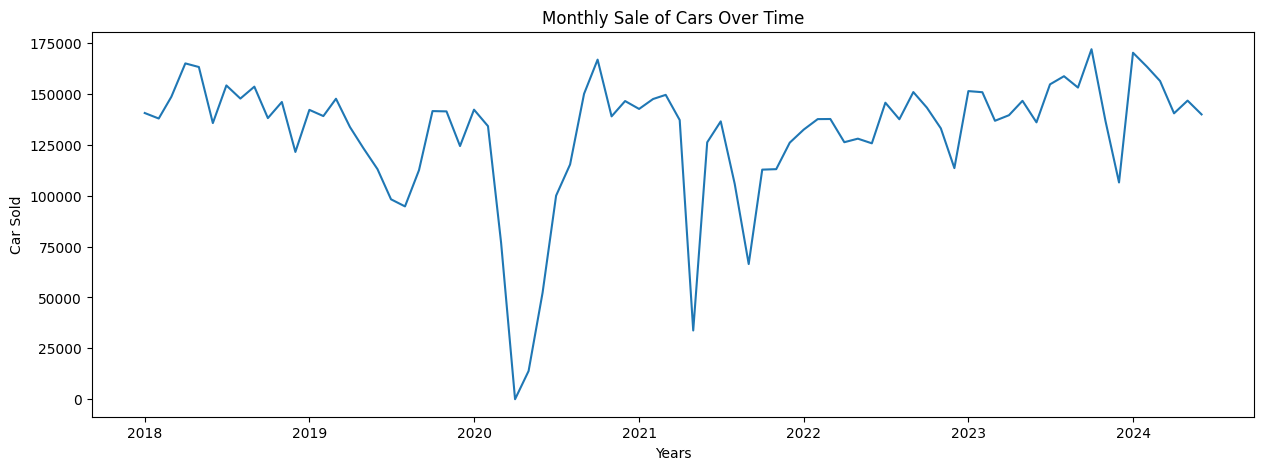

In [12]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['Date'],monthly_sales['Sale'])
plt.xlabel("Years")
plt.ylabel("Car Sold")
plt.title("Monthly Sale of Cars Over Time")
plt.show()

In [13]:
monthly_sales["sales_diff"] = monthly_sales["Sale"].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head()

,Date,Sale,sales_diff
1,2018-02-01,137900,-2700.0
2,2018-03-01,148582,10682.0
3,2018-04-01,164978,16396.0
4,2018-05-01,163200,-1778.0
5,2018-06-01,135662,-27538.0


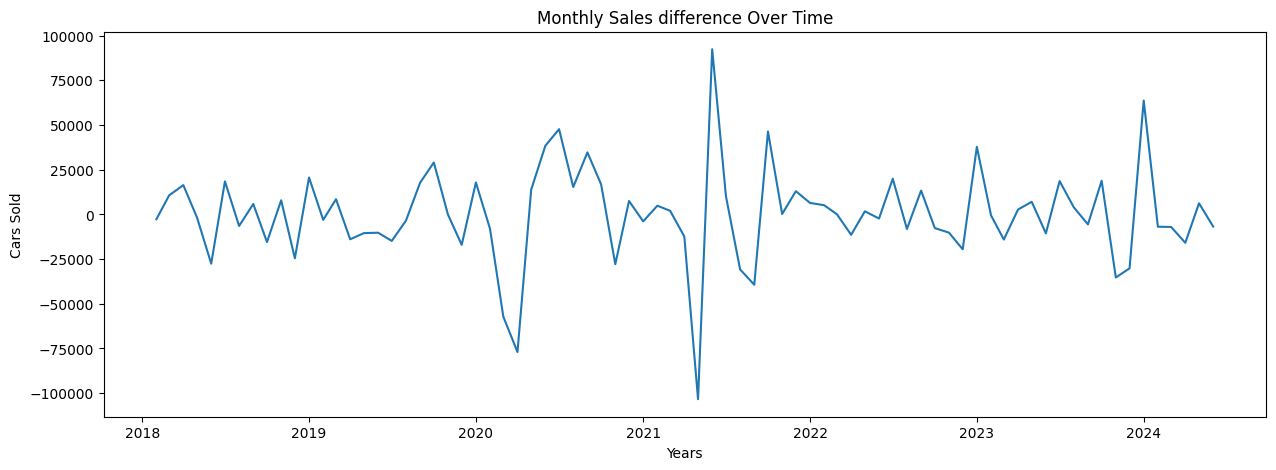

In [14]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales["Date"],monthly_sales["sales_diff"])
plt.xlabel("Years")
plt.ylabel("Cars Sold")
plt.title("Monthly Sales difference Over Time")
plt.show()

In [15]:
supervised_data = monthly_sales.drop(['Date','Sale'], axis=1)

In [16]:
for i in range(1,13):
    col_name = 'month' + str(i)
    supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head()

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,-3050.0,20671.0,-24539.0,7918.0,-15450.0,5850.0,-6450.0,18488.0,-27538.0,-1778.0,16396.0,10682.0,-2700.0
1,8513.0,-3050.0,20671.0,-24539.0,7918.0,-15450.0,5850.0,-6450.0,18488.0,-27538.0,-1778.0,16396.0,10682.0
2,-13909.0,8513.0,-3050.0,20671.0,-24539.0,7918.0,-15450.0,5850.0,-6450.0,18488.0,-27538.0,-1778.0,16396.0
3,-10454.0,-13909.0,8513.0,-3050.0,20671.0,-24539.0,7918.0,-15450.0,5850.0,-6450.0,18488.0,-27538.0,-1778.0
4,-10219.0,-10454.0,-13909.0,8513.0,-3050.0,20671.0,-24539.0,7918.0,-15450.0,5850.0,-6450.0,18488.0,-27538.0


In [17]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("Train Data shape: ", train_data.shape)
print("Test Data shape: ", test_data.shape)

Train Data shape:  (53, 13)
Test Data shape:  (12, 13)


In [18]:
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [19]:
x_train,y_train = train_data[:,1:14],train_data[:,0]
x_test,y_test = test_data[:,1:],test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (53, 12)
y_train shape:  (53,)
x_test shape:  (12, 12)
y_test shape:  (12,)


In [20]:
sales_dates = monthly_sales['Date'][-12:].reset_index(drop=True)
prediction_df = pd.DataFrame(sales_dates)

In [21]:
act_sales = monthly_sales['Sale'][-13:].to_list()
print(act_sales)

[136019, 154685, 158678, 153106, 171941, 136667, 106492, 170214, 163337, 156330, 140448, 146694, 139918]


In [22]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre = lr_model.predict(x_test)


In [23]:
lr_pre = lr_pre.reshape(-1,1)
lr_pre_test_set = np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set = scaler.inverse_transform(lr_pre_test_set)

In [24]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0] + act_sales[index])

lr_pre_series = pd.Series(result_list,name='Predicted_Sales')
prediction_df = prediction_df.merge(lr_pre_series,left_index=True,right_index=True)

In [25]:
lr_mse =np.sqrt(mean_squared_error(prediction_df['Predicted_Sales'], monthly_sales['Sale'][-12:]))
lr_mae = mean_absolute_error(prediction_df['Predicted_Sales'], monthly_sales['Sale'][-12:])
lr_r2 = r2_score = (prediction_df['Predicted_Sales'], monthly_sales['Sale'][-12:])
print("Linear Regression MSE: ",lr_mse)
print("Linear Regression MAE: ", lr_mae)
print("Linear Regression R2: ", lr_r2)

Linear Regression MSE:  24348.159583802022
Linear Regression MAE:  19919.675705673555
Linear Regression R2:  (0     131180.232320
1     158144.743341
2     146816.400315
3     155161.899337
4     166802.667960
5     122336.616597
6     113747.086428
7     186615.125377
8     131276.959167
9     163947.823438
10    152793.242644
11    128366.046640
Name: Predicted_Sales, dtype: float64, 66    154685
67    158678
68    153106
69    171941
70    136667
71    106492
72    170214
73    163337
74    156330
75    140448
76    146694
77    139918
Name: Sale, dtype: int64)


<ipython-input-26-26c93421b24a>:8: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend('Actual Sales','Predicted Sales')


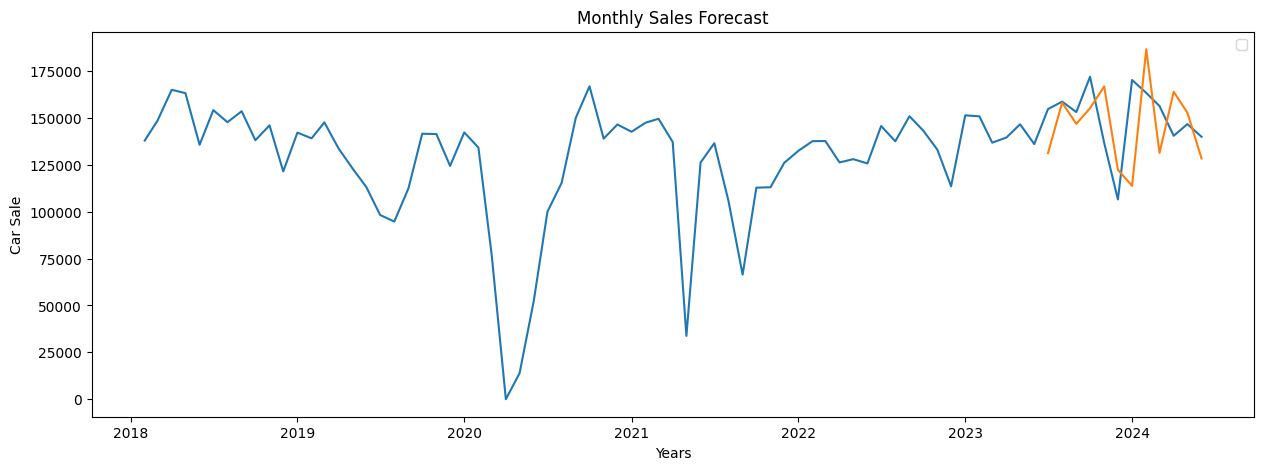

In [26]:
plt.figure(figsize=(15,5))
#Actual Sales
plt.plot(monthly_sales["Date"],monthly_sales["Sale"])
#Predicted Sales
plt.plot(prediction_df['Date'],prediction_df['Predicted_Sales'])
plt.xlabel("Years")
plt.ylabel("Car Sale")
plt.legend('Actual Sales','Predicted Sales')
plt.title("Monthly Sales Forecast")
plt.show()